## Modern model architectures

`Resnet` is quite dated. A newer model, `ConvNext` is reported to deliver better results.

We will start with the base variant of the model. Due to its size, we need to limit the batch size to 16.
Currently, I found no other way than trial and error to determine the batch size.

During the discovery of the correct batch size, I multiple times hit the memory ceiling. My `free_cuda_memory` function came in handy.

In [1]:
from fastcore.all import *
from fastai.vision.all import *

In [2]:
cheese = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(256, min_scale=0.3),
    batch_tfms=aug_transforms(mult=2))

dls = cheese.dataloaders("working/which_cheese_cleaned", bs=16)
learn = vision_learner(dls, convnext_base, metrics=accuracy)

/home/dominik/Documents/code/fastai/fastbook/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dominik/Documents/code/fastai/fastbook/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/home/dominik/Documents/code/fastai/fastbook/.venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, 

SuggestedLRs(valley=0.0010000000474974513)

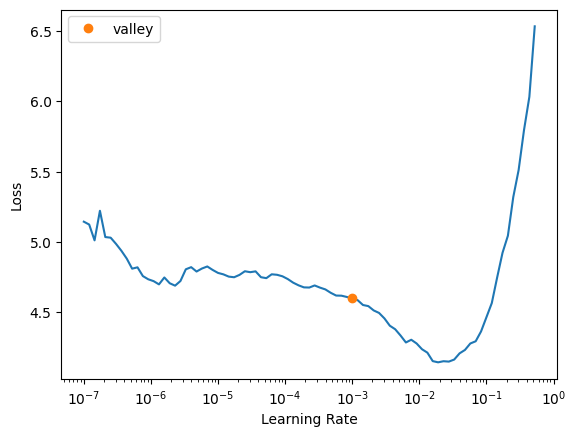

In [4]:
learn.lr_find()

In [3]:
learn.fine_tune(20, 1.e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.031354,2.283592,0.321951,00:37


epoch,train_loss,valid_loss,accuracy,time
0,2.887947,2.005787,0.385366,01:28
1,2.703871,1.712844,0.492683,01:28
2,2.446322,1.513336,0.585366,01:27
3,2.149493,1.298572,0.614634,01:30
4,1.878358,0.989779,0.712195,01:29
5,1.694279,0.902841,0.731707,01:29
6,1.502565,0.791859,0.775610,01:30
7,1.361015,0.699819,0.795122,01:30
8,1.272284,0.713360,0.809756,01:30
9,1.163435,0.629532,0.804878,01:29


The `convnext-base` model reached 83% already after 10 iterations. Afterwards, the loss improved, but accuracy did not. However, the model is big with 350mb. We will save it for later.

In [4]:
learn.export('convnext_base.pkl')

### Trying something smaller

There is also a `convnext-tiny` model, which should produce a smaller model file.

In [17]:
dls_better_tiny = cheese.dataloaders("working/which_cheese_cleaned", bs=32)
learn = vision_learner(dls_better_tiny, convnext_tiny, metrics=accuracy)

In [6]:
dls_better_tiny.bs

64

/home/dominik/Documents/code/fastai/fastbook/.venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, 

SuggestedLRs(valley=0.0014454397605732083)

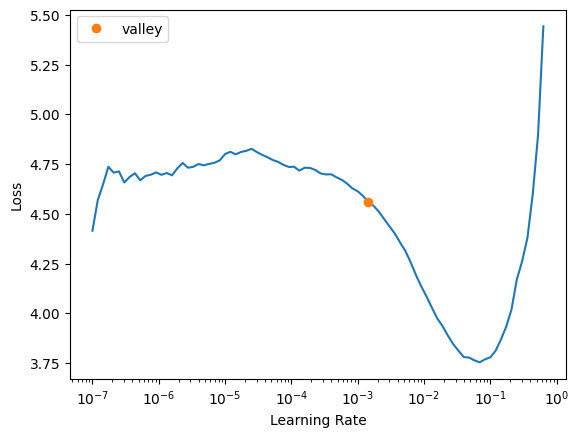

In [7]:
learn.lr_find()

In [18]:
learn.fine_tune(20,1.44e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.244600,2.932380,0.165854,00:15


epoch,train_loss,valid_loss,accuracy,time
0,3.287429,2.501591,0.287805,00:53
1,3.098157,2.106716,0.395122,00:53
2,2.910831,1.777798,0.512195,00:53
3,2.688967,1.506041,0.590244,00:53
4,2.420423,1.393299,0.653659,00:53
5,2.151483,1.200701,0.653659,00:53
6,1.887403,1.033586,0.697561,00:52
7,1.715113,0.973459,0.702439,00:53
8,1.539306,0.942053,0.702439,00:54
9,1.360577,0.849999,0.697561,00:53


In [19]:
learn.export("tiny.pkl")

The `tiny` model is not as good as the base model. However, the exported model is only 114MB. Still compared to good old resnet (47MB), that is more than twice the size.